In [2]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from utils import DataAggregator
from utils.data_visualizator import plot_confusion_matrix

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import shap
import xgboost


random_state = 42

/home/andreasols1/7-semester/ai-industry/A3I-Unibo-Project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Feature Importances

As we saw at the end of the previous notebooks it is quite difficult to predict football matches. We want to try to determine what our models deem as important to classify the full time result of a football match.

## Extreme gradient boosted trees

First, we use the package `xgboost` to train a gradient boosted tree model.

### Preprocessing


In [3]:
data_aggregator = DataAggregator()
df = data_aggregator.preprocess_data(data_aggregator.get_data(["E0"]), 
                                     date_column="Date",
                                     home_team_column="HomeTeam",
                                     away_team_column="AwayTeam",
                                     result_column="FTR",
                                     form_window=10)

df["FTR"] = df["FTR"].map({1: 2,  0: 1, -1: 0})

target = "FTR"
df_train = df[df["Date"] < "2023-07-01"]
df_test = df[df["Date"] >= "2023-07-01"]
df_test = df_test[df_test["Date"] < "2024-07-01"]

X_train = df_train.drop(columns=[target, "Date"])
y_train = df_train[target]
X_test = df_test.drop(columns=[target, "Date"])
y_test = df_test[target]

orig_col_names = X_train.columns

### Training the model

In [4]:
base_estimator = xgboost.XGBClassifier(
    tree_method="hist", importance_type="total_gain"
)
param_grid = {
    "max_depth": [2, 3, 4],
    "n_estimators": list(range(20, 41, 5)),
    "reg_lambda": np.linspace(0, 500, 12),
}
grid_search = GridSearchCV(base_estimator, param_grid=param_grid, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
xbm, xbm_params = grid_search.best_estimator_, grid_search.best_params_
xbm.get_booster().feature_names = list(orig_col_names)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
1737.99s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1738.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
1738.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debug

We can check out how a decision tree look.

<Axes: >

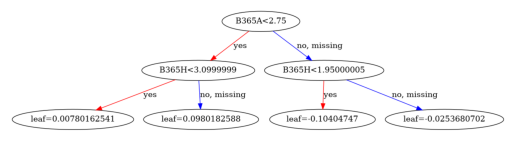

In [5]:
xgboost.plot_tree(xbm, ax=plt.gca(), num_trees=0)

We can also plot the feature importances that are given within the model we trained. Remember that we used the importance measure *total gain*.

Note that the values that are plotted in the bar chart are relative importances. I.e. $\frac{\textrm{raw importance}_i}{\sum_{j=0}^n \textrm{raw importance}_j}$

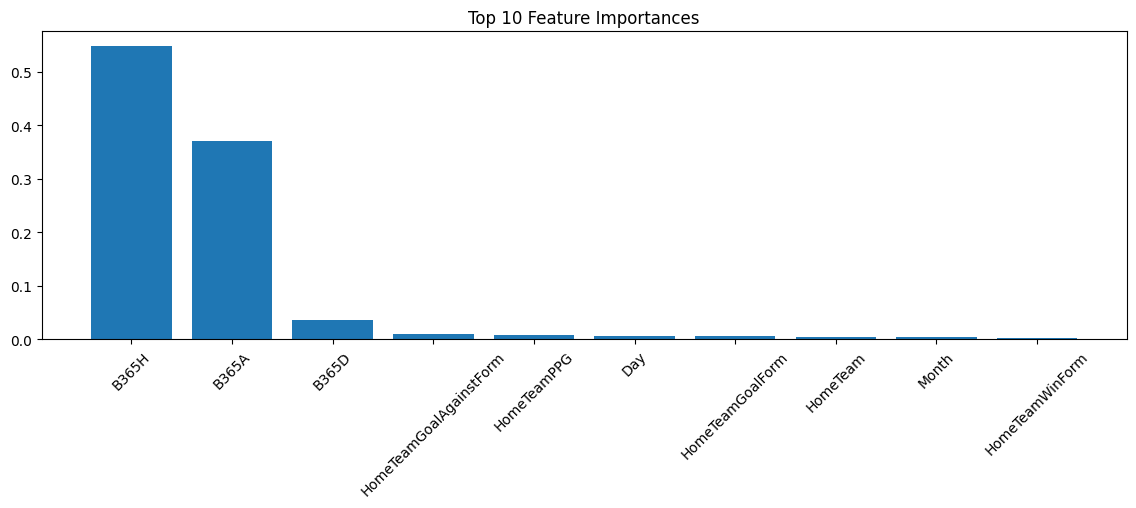

In [6]:
plt.figure(figsize=figsize)
plt.bar(pd.Series(xbm.feature_importances_, index=orig_col_names).sort_values(ascending=False).iloc[:10].index, 
    pd.Series(xbm.feature_importances_, index=orig_col_names).sort_values(ascending=False).iloc[:10])
plt.xticks(rotation=45)
plt.title("Top 10 Feature Importances")
plt.show()

From this graph, we can see that the XGBoostClassifier gives the odds from the betting site Bet365 as the most important.

In [7]:
df2= pd.DataFrame(xbm.get_booster().get_score(importance_type = "total_gain"),
             index = ["raw_importance"]).T
df2["normalized_importance"] = df2["raw_importance"] / df2["raw_importance"].sum()
df2.sort_values(by = "raw_importance", ascending = False)

,raw_importance,normalized_importance
B365H,1594.626831,0.548033
B365A,1075.980957,0.369787
B365D,103.877419,0.035700
HomeTeamGoalAgainstForm,30.664198,0.010539
HomeTeamPPG,22.895729,0.007869
Day,19.885370,0.006834
HomeTeamGoalForm,17.859930,0.006138
HomeTeam,14.555787,0.005002
Month,10.578566,0.003636
HomeTeamWinForm,8.425134,0.002896


## SHAP

We can also use Shapley Additive Explanations (SHAP) to identify another class of feature importance measures. It is further explained in the [paper by Lundberg and Lee from 2017](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf). Briefly, it is a measure on how much a feature would change the model output when considering said feature.

We compute the SHAP values of the XGBoost model we trained in previous part of this notebook.

In [8]:
f = lambda x: xbm.predict_proba(x)[:,1]
explainer_xgb = shap.KernelExplainer(f, shap.sample(X_train, 100), link='logit')
shap_values_xgb = explainer_xgb(X_test)


  0%|          | 0/380 [00:00<?, ?it/s]

100%|██████████| 380/380 [03:52<00:00,  1.64it/s]


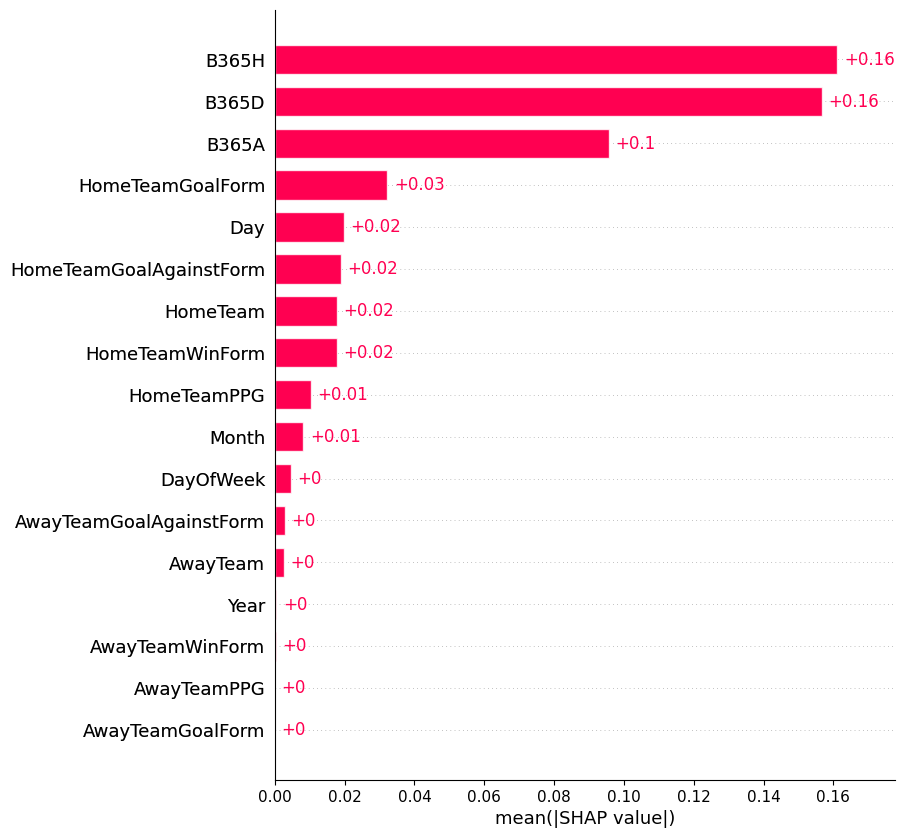

In [9]:
shap.plots.bar(shap_values_xgb, max_display=100)

In this plot, we can see that odds from Bet365 are the most important feature for classification. Betting companies have intricate models to figure out the odds for certain outcomes of sports events. They are much more complex than the models we have shown, so it makes sense that our model makes use of it.

## Random Forest Regressor

We also want to try and check the feature importances in our random forest regression model, as SHAP also can find values for random forests.

### Data preprocessing

In [3]:
data_aggregator = DataAggregator()
df = data_aggregator.get_data(["E0"])
df = data_aggregator.create_gd_feature(df)
df = data_aggregator.format_date(df, "Date")
df = data_aggregator.encode_result(
    df, mapping={"H": 1, "D": 0, "A": -1}, result_column="FTR"
)
df = data_aggregator.create_form_data(df, form_window=3)
df.drop(
    columns=[
        "Div",
        "FTHG",
        "FTAG",
        "HTHG",
        "HTAG",
        "HTR",
        "Referee",
        "HS",
        "AS",
        "HST",
        "AST",
        "HF",
        "AF",
        "HC",
        "AC",
        "HY",
        "AY",
        "HR",
        "AR",
    ],
    inplace=True,
)
df = data_aggregator.one_hot_encode_teams(df, "HomeTeam", "AwayTeam")
target = "GD"
df_train = df[df["Date"] < "2023-07-01"]
df_test = df[df["Date"] >= "2023-07-01"]
df_test = df_test[df_test["Date"] < "2024-07-01"]

X_train = df_train.drop(columns=[target, "Date", "FTR"])
y_train = df_train[target]
X_test = df_test.drop(columns=[target, "Date", "FTR"])
y_test = df_test[target]

# Scaling the data

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Training the model

In [4]:
regr = RandomForestRegressor(n_estimators=500,
                             max_depth=30,
                             random_state=random_state)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=500, random_state=42)

In [5]:
explainer = shap.TreeExplainer(regr)
shap_values_rf = explainer.shap_values(X_test)

In [ ]:
df_2 = pd.DataFrame.copy(df_test, deep=True)
df_2.drop(columns=["Date", target, "FTR"], inplace=True)

(380, 103)
(380, 106)
(380, 103)


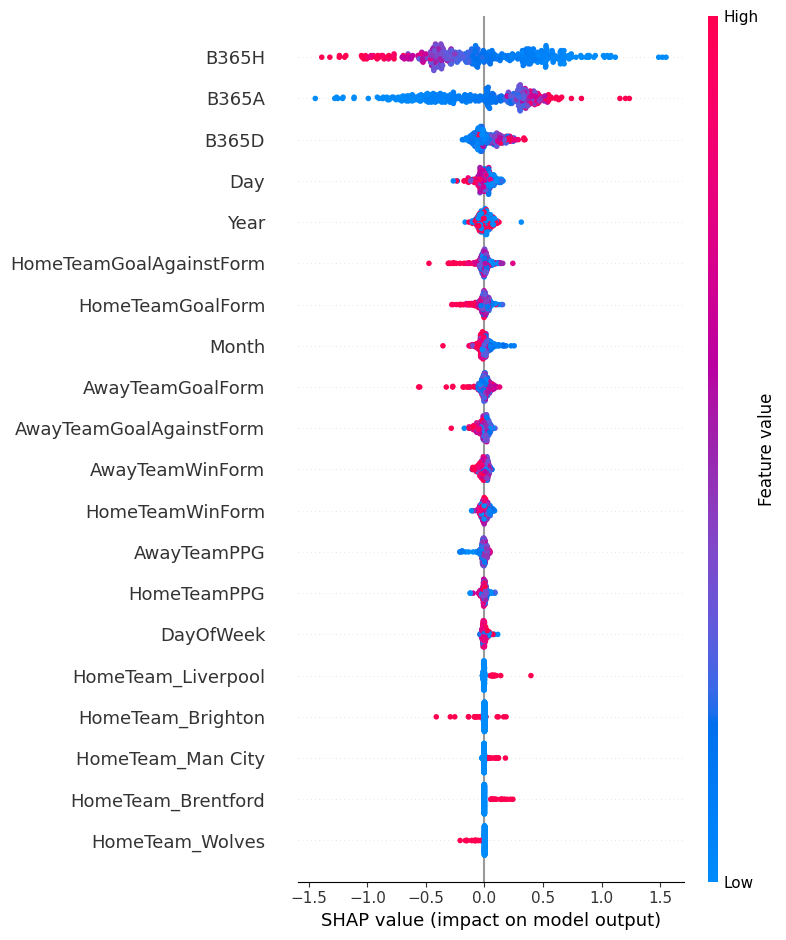

In [26]:
shap.summary_plot(shap_values_rf, X_test, feature_names=df_2.columns)